In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# mpl.rcParams['figure.figsize'] = (6,6)
# mpl.rcParams['figure.dpi'] = 100
# mpl.rcParams["image.origin"] = 'lower'

In [37]:
config = {
    "base_dir":        "/eos/home-d/dvalsecc/www/VBSPlots/DNN_archive/",
    "plot_config":     "FullRun2",
    "cut":             "res_sig",
    "model_version":   "v0_multi",
    #"model_tag":       "boost_5vars_v0",
    "samples_version": "v11",
    "cols": ['mjj_vbs_morebins',
             'vbs_0_pt',
             'vbs_1_pt', 
             'deltaeta_vbs',
             'Lepton_eta_abs',
             'vjet_0_pt', 
             'vjet_1_pt',
             'vjet_0_eta', 
             'vjet_1_eta',
             'Mtw', 
             'whad_pt',
             'Zlep', 
             ]
# A_ww
}

In [7]:
len(config["cols"])

8

```.python
# config examples
"cut":             "boos_sig_mjjincl",
"cut":             "res_sig_mjjincl",
"model_tag":       "res_4depth_v0",
 ```

In [58]:
import os

config_base_dir = os.path.join(config["base_dir"], config["plot_config"])

# create the model directory
model_dir   = os.path.join(config_base_dir, config["cut"] , "models",  config["model_version"])
os.makedirs(model_dir, exist_ok=True)

# load numpy
samples_dir = os.path.join(config_base_dir, config["cut"] , "samples", config["samples_version"])
import pickle
signal = pickle.load(open(os.path.join(samples_dir, "for_training/signal_balanced.pkl"),     "rb"))
bkg    = pickle.load(open(os.path.join(samples_dir, "for_training/background_balanced.pkl"), "rb"))

## Samples preparation for NN

In [5]:
## using 
## source /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/setup.sh
#!pip3 install --user imbalanced-learn==0.5

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from imblearn.keras import balanced_batch_generator
from imblearn.over_sampling import RandomOverSampler

Using TensorFlow backend.


In [7]:
## instead of reading the variables from file,
## we now set the variables here, and then dump them
# import yaml
# yaml_vars = yaml.safe_load(open(os.path.join(model_dir, "variables.yml")))
# print("yaml: ", type(yaml_vars), len(yaml_vars))
# cols = yaml_vars

In [9]:
X_sig = signal[config["cols"]].values
X_bkg = bkg[config["cols"]].values

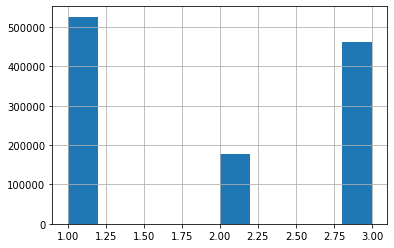

In [10]:
classes = { "VBS": 0, "Wjets":1, "top": 2, "DY": 3, "VV":4, "VBF-V":5, "VVV":6}
bkg["class"].hist()

In [11]:
enc = OneHotEncoder(categories="auto", sparse=False)

enc.fit(bkg["class"].values.reshape(-1,1))

OneHotEncoder(categorical_features=None, categories='auto', drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='error',
              n_values=None, sparse=False)

In [12]:
bkg["class"].unique()

array([2, 3, 1])

In [13]:
Y_bkg = enc.transform(bkg["class"].values.reshape(-1,1))
Y_bkg = np.hstack([np.zeros(shape=(Y_bkg.shape[0], 1)), Y_bkg])
Y_sig = np.zeros(shape=(X_sig.shape[0], 4))
Y_sig[:,0] =1

W_sig = (signal["weight_norm"]).values
W_bkg = (bkg["weight_norm"]).values
Wnn_sig = (signal["weight_"]).values
Wnn_bkg = (bkg["weight_"]).values

In [16]:
enc.transform([[3]])

array([[0., 0., 1.]])

In [17]:
Y_sig.shape

(151771, 4)

In [18]:
Y_bkg.shape

(1165192, 4)

In [19]:
X = np.vstack([X_sig, X_bkg])
Y = np.vstack([Y_sig, Y_bkg])
W = np.hstack([W_sig, W_bkg])
Wnn = np.hstack([Wnn_sig, Wnn_bkg])

In [20]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pickle.dump(scaler, open(f"{model_dir}/scaler_model.pkl", "wb"))

In [11]:
# i = 2
# print(cols[i])
# fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5), dpi=100)
# ax1.hist(X[:,i], bins=50)
# ax1.set_yscale("log")
# ax2.hist(X_scaled[:,i], weights=W, bins=50)
# plt.yscale("log")

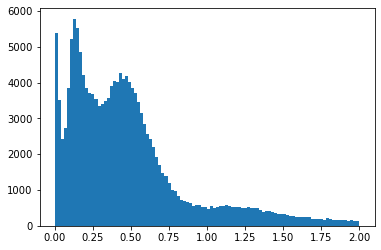

In [12]:
# _ = plt.hist(W, bins=100)
_ = plt.hist(W, bins=100, range=(0,2))

##  Balancing


In [23]:
config["test_size"] = 0.2
#config["val_size"]  = 0.5  ## test != val
config["val_size"]  = 0.0  ## test == val

X_train, X_temp, y_train, y_temp, W_train, W_temp , Wnn_train, Wnn_temp = train_test_split(X_scaled, Y,  W, Wnn, test_size=config["test_size"], random_state=42, stratify=Y)

#X_val,   X_test, y_val,   y_test, W_val,   W_test = train_test_split(X_temp,   y_temp, W_temp, test_size=config["val_size"]) ## test != val

In [24]:
print("Training   dataset: ", X_train.shape)
print("Test + Val dataset: ", X_temp.shape)
#print("Testing    dataset: ", X_test.shape)
#print("Validation dataset: ", X_val.shape)

Training   dataset:  (1053570, 8)
Test + Val dataset:  (263393, 8)


Create generators to balance signal and background

In [25]:
config["batch_size"] = 512

training_generator,   steps_per_epoch_train = balanced_batch_generator(X_train, y_train, W_train, batch_size=config["batch_size"], sampler=RandomOverSampler())
#validation_generator, steps_per_epoch_val   = balanced_batch_generator(X_val,   y_val,   W_val,   batch_size=config["batch_size"], sampler=RandomOverSampler()) ## test != val
validation_generator, steps_per_epoch_val   = balanced_batch_generator(X_temp,  y_temp,  W_temp,   batch_size=config["batch_size"], sampler=RandomOverSampler()) ## test == val

## Keras model

In [14]:
%load_ext autoreload

In [15]:
%autoreload 2

In [ ]:
# import local module that programmatically returns keras models
import dnn_models

model = dnn_models.get_model(config["model_tag"], X_train.shape[1])

model.summary()

In [42]:
from dnn_models import *

model = Sequential()
model.add(Dense(30, input_dim=X.shape[1], activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(30, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(30, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(Y.shape[1], activation="softmax"))

model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 30)                270       
_________________________________________________________________
dropout_6 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 30)                930       
_________________________________________________________________
dropout_7 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 30)                930       
_________________________________________________________________
dropout_8 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 4)                 124       
Total para

In [18]:
## import and configure the plot loss callback

import dnn_plot_loss_multi

data = {
    "X_train": X_train,
    #"X_test" : X_test, ## test != val
    "X_val" : X_temp, ## test == val
    "y_train": y_train,
    #"y_test" : y_test, ## test != val
    "y_val" : y_temp, ## test == val
    "W_train": W_train,
    #"W_test" : W_test, ## test != val
    "W_val": W_temp, ## test == val
    "Wnn_train": Wnn_train,
    #"W_test" : W_test, ## test != val
    "Wnn_val": Wnn_temp, ## test == val
}

plot_losses = dnn_plot_loss_multi.PlotLosses(model, data, batch_mode=True)

In [43]:
## TRAINING

import time
start_time = time.time()

config["epochs"] = 20

history = model.fit_generator(
            training_generator, 
            epochs=config["epochs"],
            steps_per_epoch  = steps_per_epoch_train, 
            validation_data  = validation_generator, 
            validation_steps = steps_per_epoch_val,
            callbacks=[],
            #callbacks = [], 
            )

config["train_time"] = time.time() - start_time

Epoch 1/20
3287/3287 [==============================] - 13s 4ms/step - loss: 1.1532 - acc: 0.2827 - val_loss: 1.1180 - val_acc: 0.3020
Epoch 2/20
3287/3287 [==============================] - 12s 4ms/step - loss: 1.1345 - acc: 0.2964 - val_loss: 1.1173 - val_acc: 0.2993
Epoch 3/20
3287/3287 [==============================] - 11s 3ms/step - loss: 1.1306 - acc: 0.2990 - val_loss: 1.1172 - val_acc: 0.3025
Epoch 4/20
3287/3287 [==============================] - 13s 4ms/step - loss: 1.1291 - acc: 0.3004 - val_loss: 1.1164 - val_acc: 0.3094
Epoch 5/20
3287/3287 [==============================] - 11s 3ms/step - loss: 1.1278 - acc: 0.3029 - val_loss: 1.1165 - val_acc: 0.3100
Epoch 6/20
3287/3287 [==============================] - 12s 4ms/step - loss: 1.1269 - acc: 0.3042 - val_loss: 1.1167 - val_acc: 0.3048
Epoch 7/20
3287/3287 [==============================] - 12s 4ms/step - loss: 1.1269 - acc: 0.3048 - val_loss: 1.1172 - val_acc: 0.3141
Epoch 8/20
3287/3287 [==============================] -

In [44]:
y_predict = model.predict(X_temp, batch_size=2048)

In [57]:
# fig,(axs, axs2) = plt.subplots(2, 4, figsize=(24,10))
axs[0].hist(y_predict[y_temp[:,0]==1][:,0], bins=40, range=(0.,1.), label="VBS cat", histtype="step", density=True)
axs[0].hist(y_predict[y_temp[:,0]==1][:,1], bins=40, range=(0.,1.), label="W+jets cat", histtype="step", density=True)
axs[0].hist(y_predict[y_temp[:,0]==1][:,2], bins=40, range=(0.,1.), label="Top cat", histtype="step", density=True)
axs[0].hist(y_predict[y_temp[:,0]==1][:,3], bins=40, range=(0.,1.), label="Others cat", histtype="step", density=True)
axs[0].set_title("VBS events")
axs[0].legend()

axs[1].hist(y_predict[y_temp[:,1]==1][:,0], bins=40, range=(0.,1.), label="VBS cat", histtype="step", density=True)
axs[1].hist(y_predict[y_temp[:,1]==1][:,1], bins=40, range=(0.,1.), label="W+jets cat", histtype="step", density=True)
axs[1].hist(y_predict[y_temp[:,1]==1][:,2], bins=40, range=(0.,1.), label="Top cat", histtype="step", density=True)
axs[1].hist(y_predict[y_temp[:,1]==1][:,3], bins=40, range=(0.,1.), label="Others cat", histtype="step", density=True)
axs[1].set_title("W+Jets events")
axs[1].legend()

axs[2].hist(y_predict[y_temp[:,2]==1][:,0], bins=40, range=(0.,1.), label="VBS cat", histtype="step", density=True)
axs[2].hist(y_predict[y_temp[:,2]==1][:,1], bins=40, range=(0.,1.), label="W+jets cat", histtype="step", density=True)
axs[2].hist(y_predict[y_temp[:,2]==1][:,2], bins=40, range=(0.,1.), label="Top cat", histtype="step", density=True)
axs[2].hist(y_predict[y_temp[:,2]==1][:,3], bins=40, range=(0.,1.), label="Others cat", histtype="step", density=True)
axs[2].set_title("Top events")
axs[2].legend()

axs[3].hist(y_predict[y_temp[:,3]==1][:,0], bins=40, range=(0.,1.), label="VBS cat", histtype="step", density=True)
axs[3].hist(y_predict[y_temp[:,3]==1][:,1], bins=40, range=(0.,1.), label="W+jets cat", histtype="step", density=True)
axs[3].hist(y_predict[y_temp[:,3]==1][:,2], bins=40, range=(0.,1.), label="Top cat", histtype="step", density=True)
axs[3].hist(y_predict[y_temp[:,3]==1][:,3], bins=40, range=(0.,1.), label="Others cat", histtype="step", density=True)
axs[3].set_title("Other events")
axs[3].legend()

#######
#categories

axs2[0].hist(y_predict[y_temp[:,0]==1][:,0], bins=40, range=(0.,1.), label="VBS events", histtype="step", density=True, cumulative=-1)
axs2[0].hist(y_predict[y_temp[:,1]==1][:,0], bins=40, range=(0.,1.), label="W+jets events", histtype="step", density=True)
axs2[0].hist(y_predict[y_temp[:,2]==1][:,0], bins=40, range=(0.,1.), label="Top events", histtype="step", density=True)
axs2[0].hist(y_predict[y_temp[:,3]==1][:,0], bins=40, range=(0.,1.), label="Others events", histtype="step", density=True)
axs2[0].hist(y_predict[y_temp[:,0]!=1][:,0], bins=40, range=(0.,1.), label="All BKG", histtype="step", density=True)
axs2[0].set_title("VBS category")
axs2[0].set_yscale("log")
axs2[0].legend()

axs2[1].hist(y_predict[y_temp[:,0]==1][:,1], bins=40, range=(0.,1.), label="VBS events", histtype="step", density=True)
axs2[1].hist(y_predict[y_temp[:,1]==1][:,1], bins=40, range=(0.,1.), label="W+jets events", histtype="step", density=True)
axs2[1].hist(y_predict[y_temp[:,2]==1][:,1], bins=40, range=(0.,1.), label="Top events", histtype="step", density=True)
axs2[1].hist(y_predict[y_temp[:,3]==1][:,1], bins=40, range=(0.,1.), label="Others events", histtype="step", density=True)
axs2[1].set_title("W+Jets category")
axs2[1].legend()

axs2[2].hist(y_predict[y_temp[:,0]==1][:,2], bins=40, range=(0.,1.), label="VBS events", histtype="step", density=True)
axs2[2].hist(y_predict[y_temp[:,1]==1][:,2], bins=40, range=(0.,1.), label="W+jets events", histtype="step", density=True)
axs2[2].hist(y_predict[y_temp[:,2]==1][:,2], bins=40, range=(0.,1.), label="Top events", histtype="step", density=True)
axs2[2].hist(y_predict[y_temp[:,3]==1][:,2], bins=40, range=(0.,1.), label="Others events", histtype="step", density=True)
axs2[2].set_title("Top category")
axs2[2].legend()

axs2[3].hist(y_predict[y_temp[:,0]==1][:,3], bins=40, range=(0.,1.), label="VBS events", histtype="step", density=True)
axs2[3].hist(y_predict[y_temp[:,1]==1][:,3], bins=40, range=(0.,1.), label="W+jets events", histtype="step", density=True)
axs2[3].hist(y_predict[y_temp[:,2]==1][:,3], bins=40, range=(0.,1.), label="Top events", histtype="step", density=True)
axs2[3].hist(y_predict[y_temp[:,3]==1][:,3], bins=40, range=(0.,1.), label="Others events", histtype="step", density=True)
axs2[3].set_title("Other category")
axs2[3].legend()


In [21]:
config["train_time"]

33.990073442459106

In [22]:
## SAVE THE MODEL, ITS METADATA AND TRAINING INFORMATIONS

# dump the variables list
import yaml
varfile = os.path.join(model_dir, "variables.yml")
if os.path.isfile(varfile):
    print("ACHTUNG! variables file already existing: old file renamed with '_old'")
    os.rename(varfile, varfile[:-4] + "_old.yml")
with open(varfile, "w") as out_var_file:
    out_var_file.write(yaml.dump(config["cols"]))
    
# dump the config
config["a__model_dir"] = model_dir
model_config_file = os.path.join(model_dir, "model_config.yml")
if os.path.isfile(model_config_file):
    print("ACHTUNG! model_config_file file already existing: old file renamed with '_old'")
    os.rename(model_config_file, model_config_file[:-4] + "_old.yml")
with open(model_config_file, "w") as out_var_file:
    out_var_file.write(yaml.dump(config))  

# save figure with training summary
plot_losses.save_figure( os.path.join(model_dir, "model_train.png") )

# save keras model
model.save( os.path.join(model_dir, "model.h5") )

In [23]:
## Export:
## * keras model to tensorflow model
## * tf metadata
## * scaler

args = {
    "dir": model_dir,
    "input": "model.h5",
    "output": "model.pb",
    "tf_metadata": "tf_metadata.txt",
    "input_scaler": "scaler_model.pkl",
    "output_scaler": "scaler.txt",
}


from keras import backend as K
# This line must be executed before loading Keras model.
K.set_learning_phase(0)

from keras.models import load_model
model = load_model(os.path.join(args["dir"], args["input"]))

from keras import backend as K
import tensorflow as tf

def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        # Graph -> GraphDef ProtoBuf
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                      output_names, freeze_var_names)
        return frozen_graph


frozen_graph = freeze_session(K.get_session(),
                              output_names=[out.op.name for out in model.outputs])

# Save to ./model/tf_model.pb
tf.train.write_graph(frozen_graph, args["dir"], args["output"], as_text=False)

## save tensorflow metadata
with open(os.path.join(args["dir"], args["tf_metadata"]), "w") as f:
    f.write(str(model.inputs[0].name) + " " + str(model.outputs[0].name) + "\n")


## Export 
## * tf tensor input name and output name
## * scaler mean_ and scale_ (where scale_ = np.sqrt(var_)) for each variable
##
import os
import pickle

import yaml
yaml_vars = yaml.safe_load(open(os.path.join(args["dir"], "variables.yml"), "r"))

scaler = pickle.load(open(os.path.join(args["dir"], args["input_scaler"]), 'rb'))
with open(os.path.join(args["dir"], args["output_scaler"]), "w") as f:
    for var, mean, scale in zip(yaml_vars, scaler.mean_, scaler.scale_):
        f.write(var + " " + str(mean) + " " + str(scale) + "\n")


W0310 23:06:43.475929 139772135913280 deprecation.py:323] From <ipython-input-23-39c8d219d3f3>:53: convert_variables_to_constants (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
W0310 23:06:43.477826 139772135913280 deprecation.py:323] From /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/tensorflow/python/framework/graph_util_impl.py:270: extract_sub_graph (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


In [24]:
## Retrieve graphs history
## plot 
# n = 30
# plt.hist(plot_losses.dnn_score_plot[n][0][1][:-1], bins=plot_losses.dnn_score_plot[n][0][1], weights=plot_losses.dnn_score_plot[n][0][0], histtype="step")
# plt.hist(plot_losses.dnn_score_plot[n][1][1][:-1], bins=plot_losses.dnn_score_plot[n][1][1], weights=plot_losses.dnn_score_plot[n][1][0], histtype="step")

### Columns List

```.python
# resolved
    "cols": ['mjj_vbs', 
             'vbs_0_pt', 
             'vbs_1_pt', 
             'deltaeta_vbs',
             'deltaphi_vbs', 
             'mjj_vjet', 
             'vjet_0_pt', 
             'vjet_1_pt', 
             'vjet_0_eta', 
             'vjet_1_eta', 
             'Lepton_pt', 
             'Lepton_eta', 
             'Lepton_flavour', 
             'PuppiMET', 
             'Zvjets_0', 
             'Zlep', 
             'Asym_vbs', 
             'Asym_vjet', 
             'A_ww', 
             'Mtw_lep', 
             'w_lep_pt', 
             'Mww', 
             'R_ww', 
             'R_mw', 
             'Centr_vbs', 
             'Centr_ww'
         ]

# boosted
    "cols": ['mjj_vbs', 
             'vbs_0_pt', 
             'vbs_1_pt', 
             'deltaeta_vbs',
             'deltaphi_vbs', 
             'mjj_vjet', 
             'vjet_0_pt', 
             'vjet_1_pt', 
             'vjet_0_eta', 
             'vjet_1_eta', 
             'Lepton_pt', 
             'Lepton_eta', 
             'Lepton_flavour', 
             'PuppiMET', 
             'Zvjets_0', 
             'Zlep', 
             'Asym_vbs', 
             'Asym_vjet', 
             'A_ww', 
             'Mtw_lep', 
             'w_lep_pt', 
             'Mww', 
             'R_ww', 
             'R_mw', 
             'Centr_vbs', 
             'Centr_ww'
         ]

         
# OLD
    "cols": ['mjj_vbs', 'deltaeta_vbs', 
            'mjj_vjet', 
            'Lepton_pt', 'Lepton_eta' ]
    "cols": ['mjj_vbs', 
             'vbs_0_pt', 'vbs_1_pt', 
             'deltaeta_vbs', 'deltaphi_vbs', 
             'mjj_vjet', 
             'vjet_0_pt', 'vjet_1_pt', 
             'vjet_0_eta', 'vjet_1_eta', 
             'Lepton_pt', 'Lepton_eta', 'Lepton_flavour', 
         ]
```